In [19]:
from keras.applications import Xception
import os
import numpy as np
import cv2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline


## Model Download

In [20]:
import tensorflow as tf
from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)


In [21]:
image_size = 221
resnet_conv = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size,3))

In [22]:
for layer in resnet_conv.layers[:-4]:     
    layer.trainable = False
for layer in resnet_conv.layers:
    print(layer, layer.trainable)

(<keras.engine.input_layer.InputLayer object at 0x7f70fe5168d0>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f70fe516d50>, False)
(<keras.layers.normalization.BatchNormalization object at 0x7f70fe4fe2d0>, False)
(<keras.layers.core.Activation object at 0x7f70fe4fe0d0>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f70a63d2e10>, False)
(<keras.layers.normalization.BatchNormalization object at 0x7f70a6f73c50>, False)
(<keras.layers.core.Activation object at 0x7f70a63d6b10>, False)
(<keras.layers.convolutional.SeparableConv2D object at 0x7f70a633e3d0>, False)
(<keras.layers.normalization.BatchNormalization object at 0x7f70a632ffd0>, False)
(<keras.layers.core.Activation object at 0x7f70a6282750>, False)
(<keras.layers.convolutional.SeparableConv2D object at 0x7f70a62bfc50>, False)
(<keras.layers.normalization.BatchNormalization object at 0x7f70a6144a10>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f70a63a1750>, False)
(<keras.layers.pooling.MaxPooling2D o

## Creating a new Model


In [23]:
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')


# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(resnet_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.75))
model.add(layers.Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 123,625,002
Trainable params: 105,927,170
Non-trainable params: 17,697,832
_________________________________________________________________


## Setup data generators

In [6]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 50
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        '../../data/deep_learn/train/',
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        '../../data/deep_learn/teste/',
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=True)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              #optimizer='sgd',
              metrics=['acc'])


In [8]:
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,verbose=1)


Epoch 1/20
30/30 [==============================] - 88s 3s/step - loss: 1.5479 - acc: 0.7667 - val_loss: 4.8216 - val_acc: 0.5560
Epoch 2/20
30/30 [==============================] - 87s 3s/step - loss: 0.4969 - acc: 0.8847 - val_loss: 1.3958 - val_acc: 0.8320
Epoch 3/20
30/30 [==============================] - 88s 3s/step - loss: 0.3006 - acc: 0.9340 - val_loss: 0.6218 - val_acc: 0.9140
Epoch 4/20
30/30 [==============================] - 85s 3s/step - loss: 0.3728 - acc: 0.9213 - val_loss: 1.7898 - val_acc: 0.8040
Epoch 5/20
30/30 [==============================] - 87s 3s/step - loss: 0.3292 - acc: 0.9267 - val_loss: 0.4669 - val_acc: 0.9340
Epoch 6/20
30/30 [==============================] - 85s 3s/step - loss: 0.2595 - acc: 0.9407 - val_loss: 0.9116 - val_acc: 0.8940
Epoch 7/20
30/30 [==============================] - 88s 3s/step - loss: 0.2341 - acc: 0.9467 - val_loss: 0.6071 - val_acc: 0.9320
Epoch 8/20
30/30 [==============================] - 85s 3s/step - loss: 0.1788 - acc: 0.96

In [9]:
 
# Save the model
model.save('estomato_xception.h5')

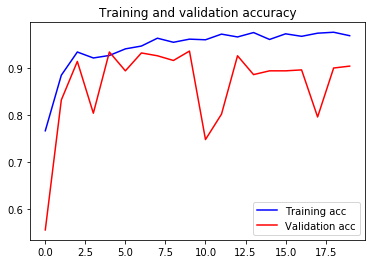

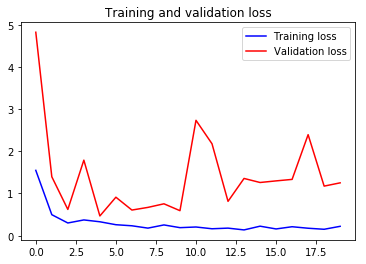

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [11]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        '../../data/deep_learn/teste/',
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)


Found 500 images belonging to 2 classes.


50/50 [==============================] - 26s 515ms/step
No of errors = 48/500


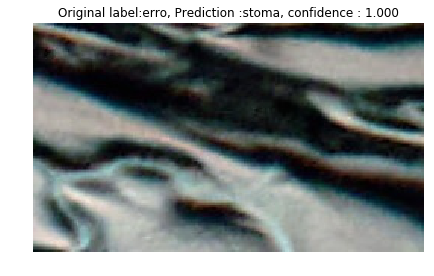

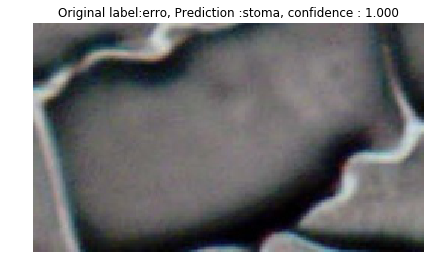

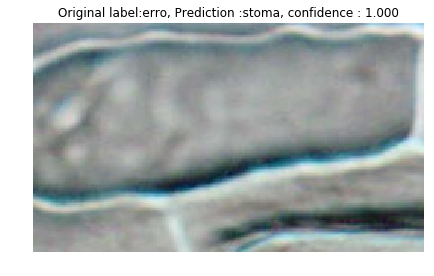

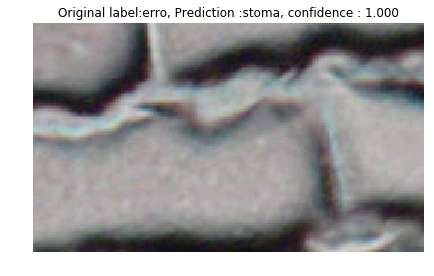

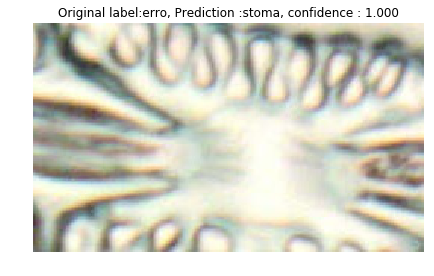

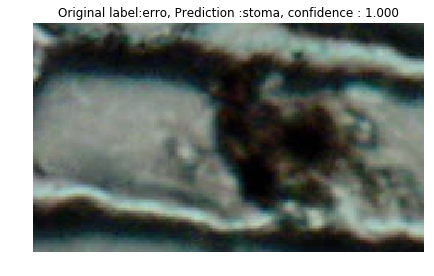

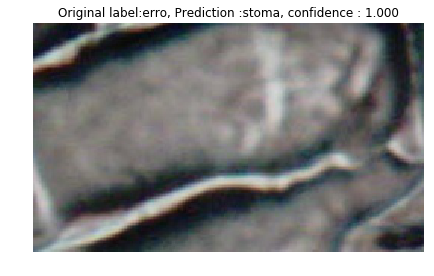

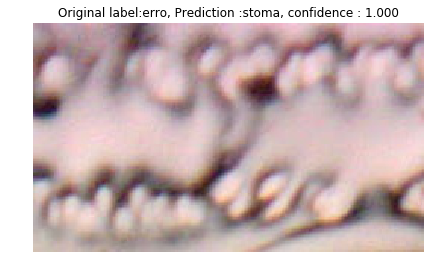

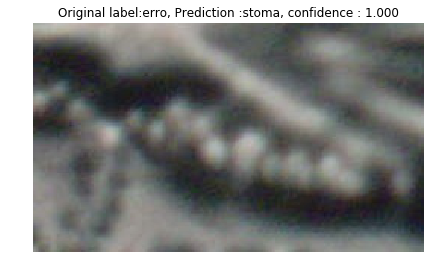

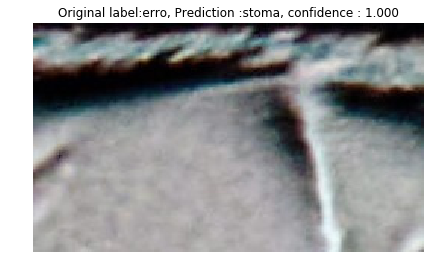

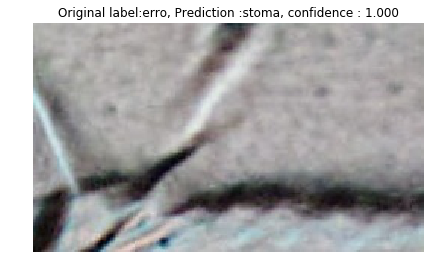

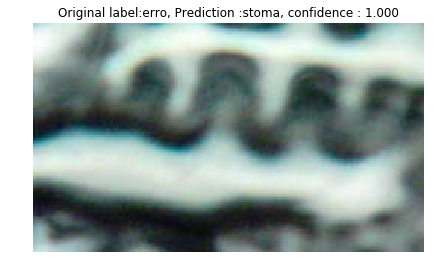

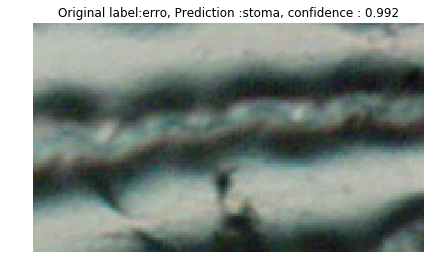

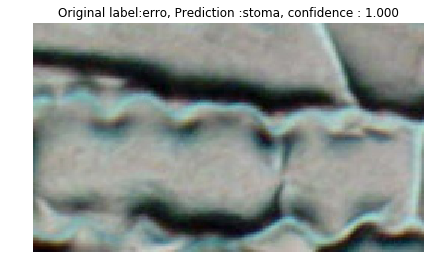

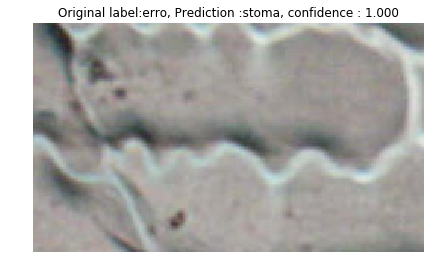

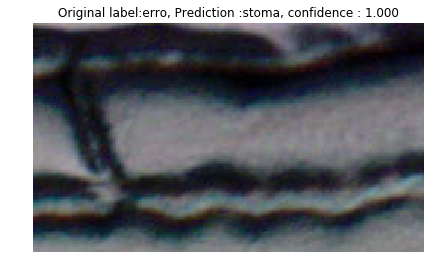

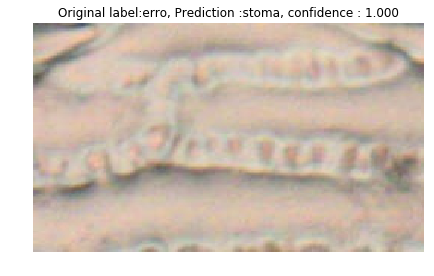

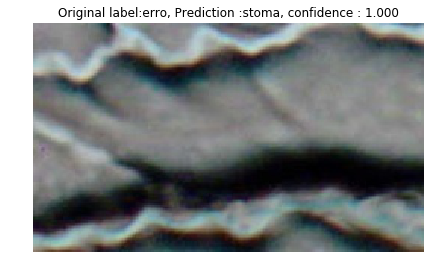

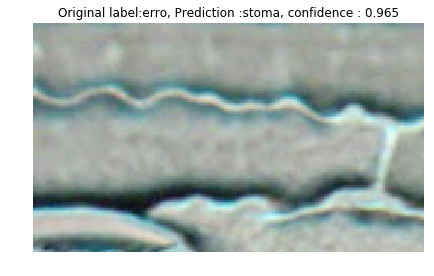

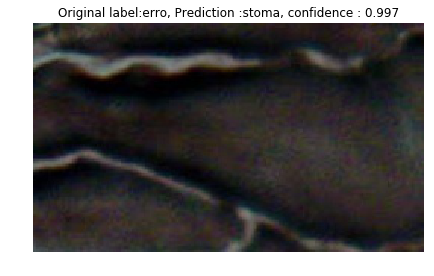

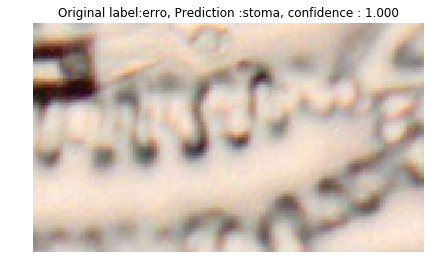

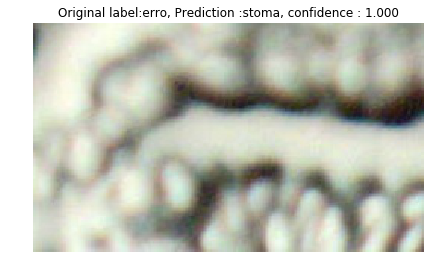

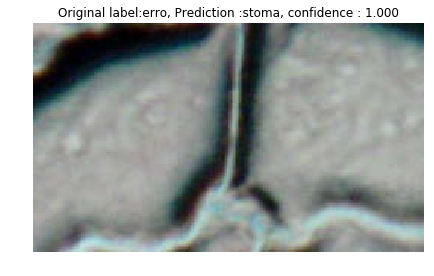

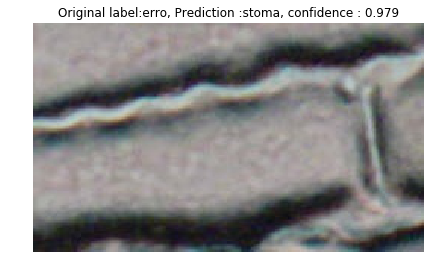

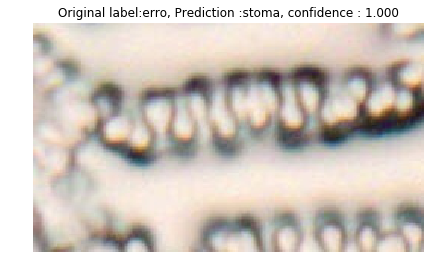

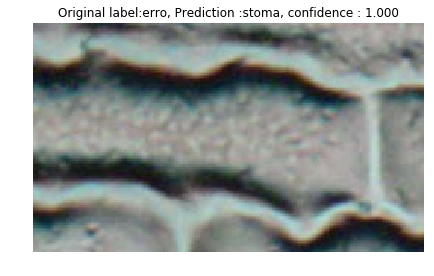

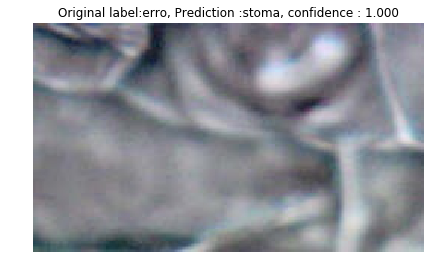

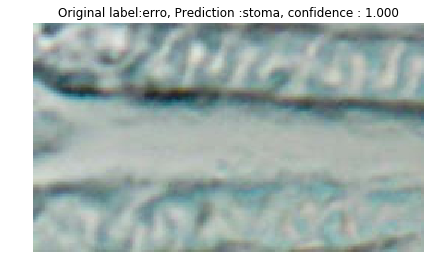

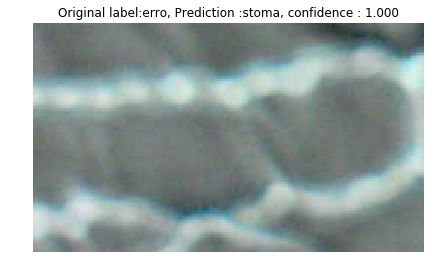

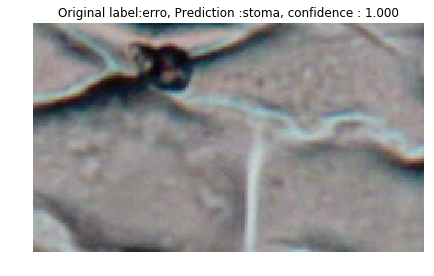

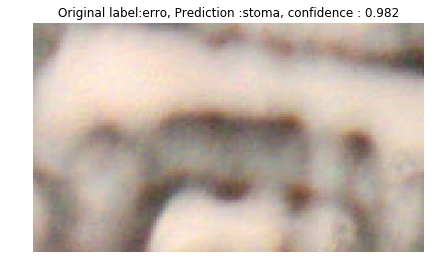

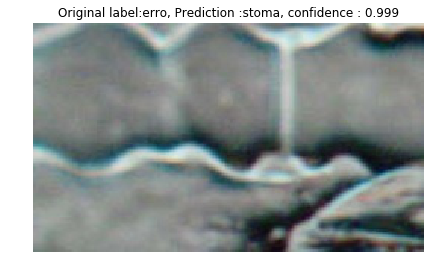

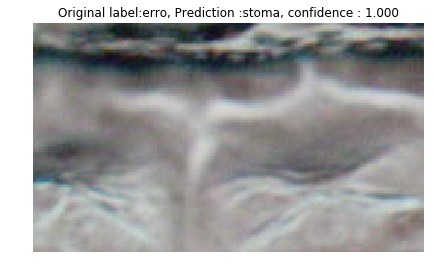

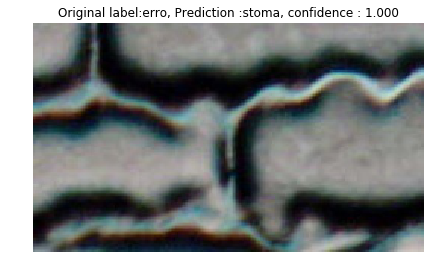

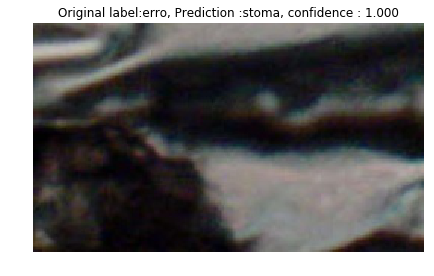

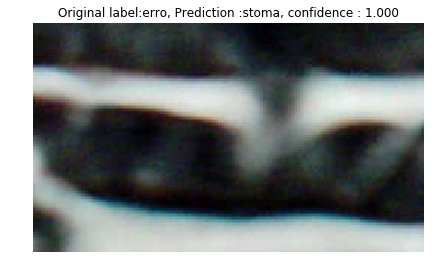

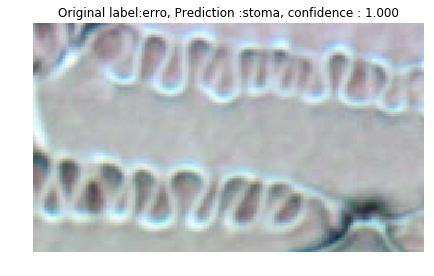

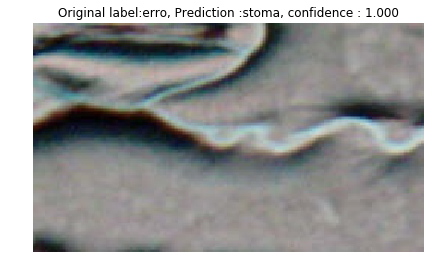

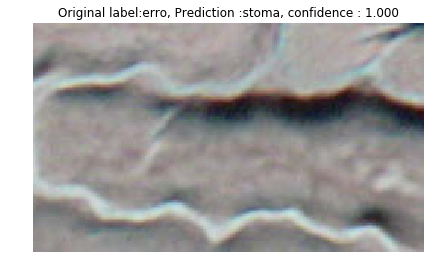

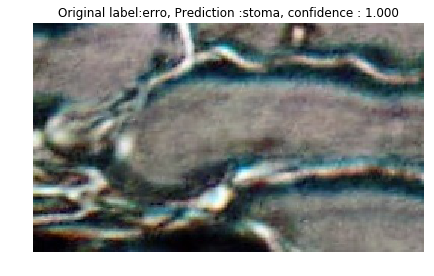

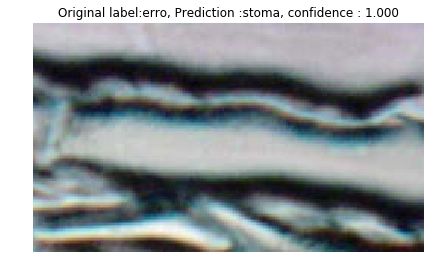

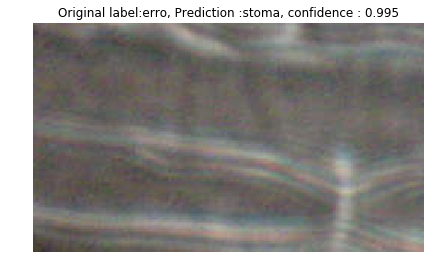

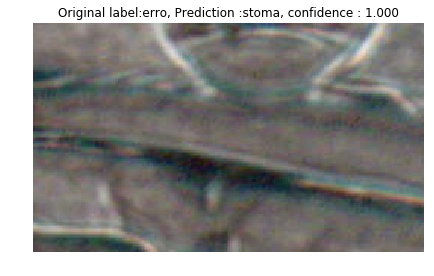

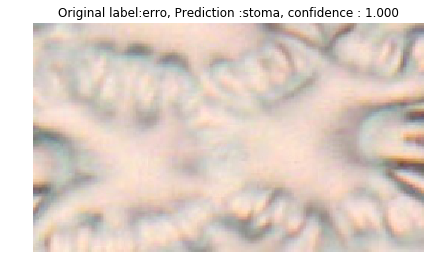

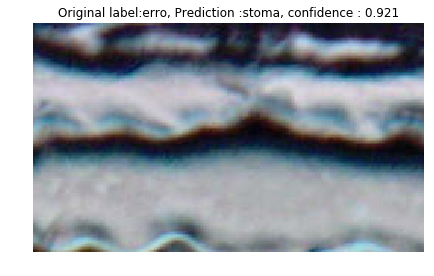

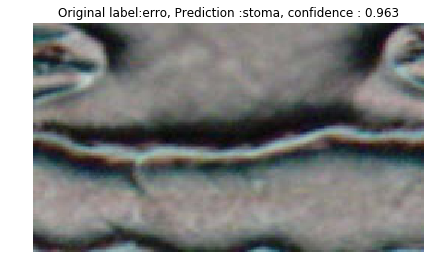

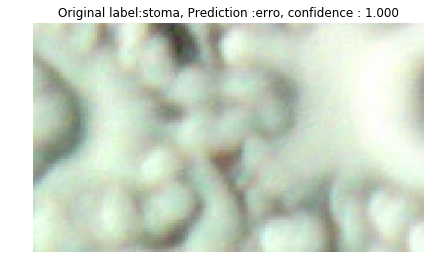

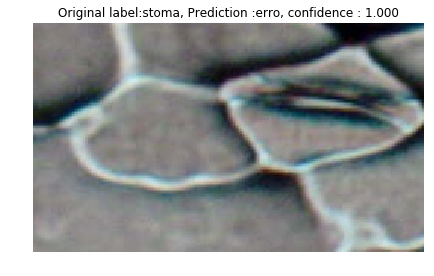

In [12]:
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = load_img('{}/{}'.format('/home/nagai/Documents/Projects/Estomatos_PI/Imagens/data_final/deep_learn/teste/',fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              #optimizer='sgd',
              metrics=['acc'])


In [ ]:
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,verbose=1)


Epoch 1/5
